In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
#Read the training and testing sets from the Excel file
file_path = r'D:\BaiduSyncdisk\Data_FUI\模型训练\new\Chla\excel\Chla_best_train_test_data.xlsx'
train_sheet_name = 'Training Set'
test_sheet_name = 'Test Set'

train_data = pd.read_excel(file_path, sheet_name=train_sheet_name)
test_data = pd.read_excel(file_path, sheet_name=test_sheet_name)

spectrum_start = 7
spectrum_end = 21
Chla = 4

#Specify the column names for other feature columns
other_feature_columns = ['b10/b9', '(b7+b11)/b8', 'Cluster']

#Extract spectral data column and chlorophyll concentration column
X_spectral_train = train_data.iloc[:, spectrum_start - 1:spectrum_end].values
y_train = train_data.iloc[:, Chla - 1].values

X_spectral_test = test_data.iloc[:, spectrum_start - 1:spectrum_end].values
y_test = test_data.iloc[:, Chla - 1].values

#Extract other feature columns
X_other_train = train_data[other_feature_columns].values
X_other_test = test_data[other_feature_columns].values

def extract_features(spectral_data):
    features = []
    for spectrum in spectral_data:
        max_val = np.max(spectrum)
        min_val = np.min(spectrum)
        peak_indices, _ = find_peaks(spectrum)
        trough_indices, _ = find_peaks(-spectrum)

        if peak_indices.size > 0:
            peak_val = spectrum[peak_indices[0]]
        else:
            peak_val = np.nan

        if trough_indices.size > 0:
            trough_val = spectrum[trough_indices[0]]
        else:
            trough_val = np.nan

        curvature = np.gradient(np.gradient(spectrum))
        convexity = np.mean(curvature)

        # Calculate slope
        slope = (spectrum[-1] - spectrum[0]) / (len(spectrum) - 1)

        # Calculate rise and fall amplitude
        rise_amplitude = np.max(np.diff(spectrum))
        fall_amplitude = np.min(np.diff(spectrum))

        features.append([max_val, min_val, peak_val, trough_val, convexity, slope, rise_amplitude, fall_amplitude])

    return np.array(features)

#Extract spectral features from the training and testing sets
X_spectral_train_features = extract_features(X_spectral_train)
X_spectral_test_features = extract_features(X_spectral_test)

#Combine spectral features with other features
X_train_features = np.hstack((X_spectral_train_features, X_other_train))
X_test_features = np.hstack((X_spectral_test_features, X_other_test))

#Building a CatBoost model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    random_seed=42,
    loss_function='RMSE',
    l2_leaf_reg=1,
    verbose=0
)
model.fit(X_train_features, y_train)

#Predicting training and testing sets
y_train_pred = model.predict(X_train_features)
y_test_pred = model.predict(X_test_features)

#Evaluate the performance of the model on the training and testing sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Training Set Mean Squared Error: {train_mse}')
print(f'Training Set R^2 Score: {train_r2}')
print(f'Training Set MAPE: {train_mape}')
print(f'Test Set Mean Squared Error: {test_mse}')
print(f'Test Set R^2 Score: {test_r2}')
print(f'Test Set MAPE: {test_mape}')

Training Set Mean Squared Error: 9.711656244741354
Training Set R^2 Score: 0.9224640117432615
Training Set MAPE: 1.5336617399095582
Test Set Mean Squared Error: 8.21839100394338
Test Set R^2 Score: 0.8835141505328963
Test Set MAPE: 1.100241354560954


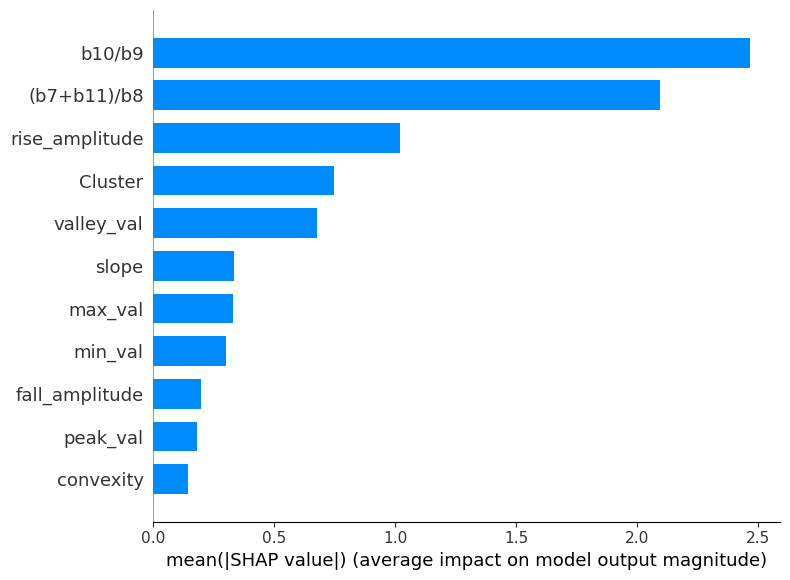

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


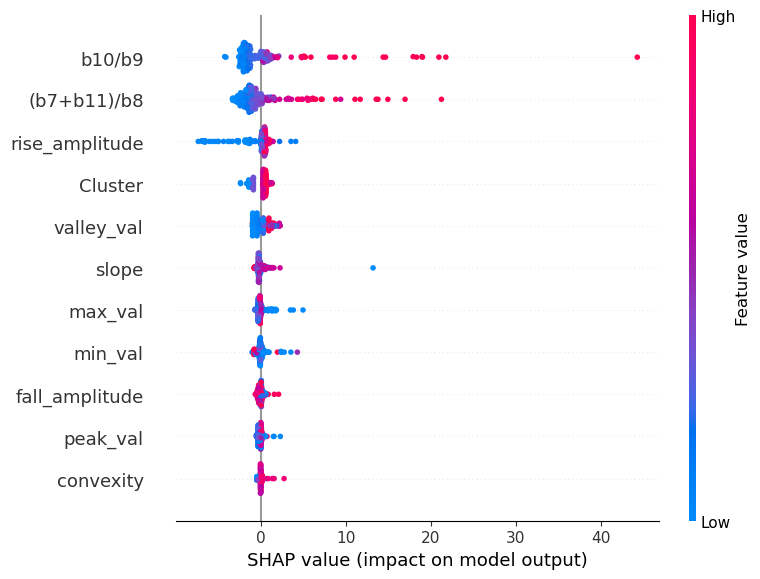

In [4]:
import shap
feature_names = [
    'max_val', 'min_val', 'peak_val', 'valley_val', 'convexity', 'slope', 
    'rise_amplitude', 'fall_amplitude', 'b10/b9', '(b7+b11)/b8', 'Cluster'
]

#Explain using SHAP
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_features)
shap_values_test = explainer.shap_values(X_test_features)

shap.summary_plot(shap_values_train, X_train_features, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values_train, X_train_features, feature_names=feature_names)

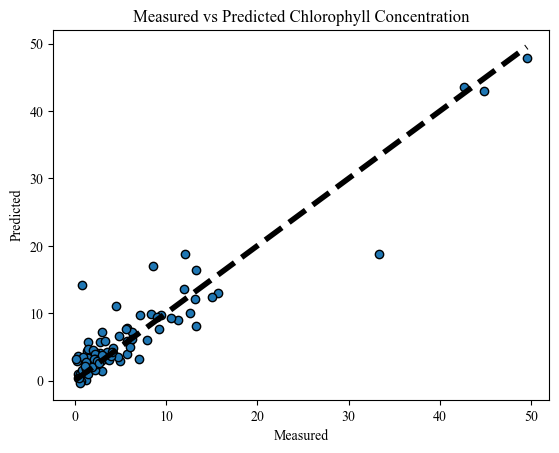

In [6]:
#Visualize prediction results
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Chlorophyll Concentration')
plt.savefig('image/Measured vs Predicted Chlorophyll Concentration.jpg')
plt.show()

The figure layout has changed to tight


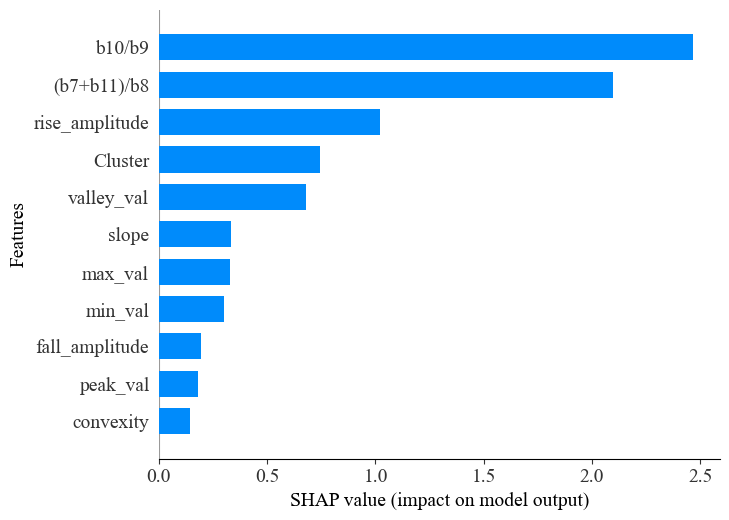

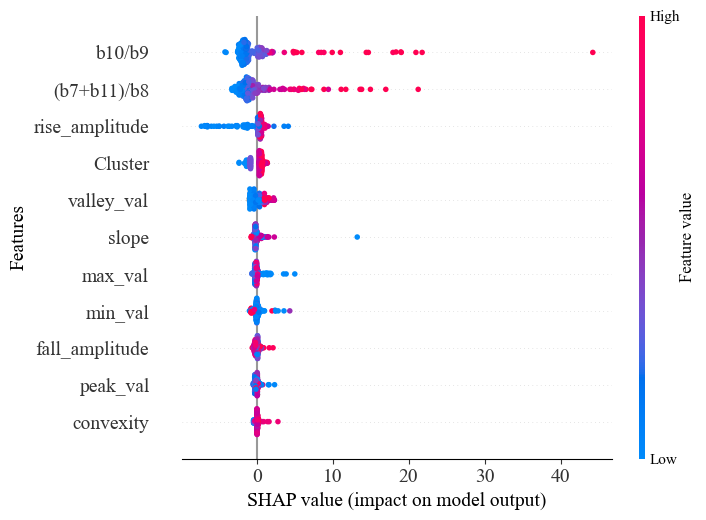

In [5]:
import shap
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Set font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 30  #Set the global font size to 14

#Customize the length of the horizontal axis
def custom_summary_plot(shap_values, features, feature_names=None, plot_type="dot"):
    #Set the width of the diagram to 10cm (1 inch is approximately 2.54cm, so 10cm is approximately 3.94 inches)
    plt.figure(figsize=(3.94, 5))
    shap.summary_plot(shap_values, features, feature_names=feature_names, plot_type=plot_type, show=False)
    plt.xticks(fontsize=14)  #Set the font size for the horizontal axis
    plt.yticks(fontsize=14)  #Set vertical font size
    plt.xlabel('SHAP value (impact on model output)', fontsize=14)  #Set the font size of the horizontal axis label
    plt.ylabel('Features', fontsize=14)  #Set the font size of the vertical axis label
    # plt.title('SHAP Summary Plot', fontsize=16)  #Set the font size for the title
   
    plt.tight_layout()  #Adjust subgraph layout
    plt.savefig('shap_summary_plot.png')  #Optional: Save Image
    plt.show()

feature_names = [
    'max_val', 'min_val', 'peak_val', 'valley_val', 'convexity', 'slope', 
    'rise_amplitude', 'fall_amplitude', 'b10/b9', '(b7+b11)/b8', 'Cluster'
]

#Explain using SHAP
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_features)
shap_values_test = explainer.shap_values(X_test_features)

#Draw SHAP explanatory diagram
custom_summary_plot(shap_values_train, X_train_features, feature_names=feature_names, plot_type="bar")
custom_summary_plot(shap_values_train, X_train_features, feature_names=feature_names)
